In [1]:
# Cell 1 - Imports & setup
import os
import numpy as np
import pandas as pd
import joblib
import mlflow
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier

import sys
import os
sys.path.append(os.path.abspath(".."))
from src.utils import save_df, save_oof, save_json, load_json
from src.metrics import multiclass_and_binary_metrics
from src.preprocess import basic_preprocess

mlflow.set_experiment("iml2025_project")
os.makedirs("../models", exist_ok=True)
os.makedirs("../logs/metrics", exist_ok=True)


2025/12/07 13:50:21 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/07 13:50:21 INFO mlflow.store.db.utils: Updating database tables
2025/12/07 13:50:21 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 13:50:21 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/07 13:50:21 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 13:50:21 INFO alembic.runtime.migration: Will assume non-transactional DDL.


In [3]:
# Cell 2 - Load data & class_list
train = pd.read_csv("../data/train.csv")
train['class2'] = (train['class4'] != 'nonevent').astype(int)
class_list = save_json  # placeholder to avoid linter; we will load properly

class_list = load_json("../models/class_list.json")
print("Using class_list:", class_list)

X = train.drop(columns=["id","date","class4","class2", "partlybad"])
y_class4 = train['class4'].values


Using class_list: ['II', 'Ia', 'Ib', 'nonevent']


**Created Features -Add to the report**

In [ ]:
# Cell 3 - Simple feature engineering: CV (std/abs(mean)), group aggregates
X_fe = X.copy()
# create coefficient-of-variation features for mean/std pairs
mean_cols = [c for c in X_fe.columns if ".mean" in c]
for m in mean_cols:
    base = m.replace(".mean", "")
    s = base + ".std"
    if s in X_fe.columns:
        newc = base + "_cv"
        X_fe[newc] = X_fe[s] / (X_fe[m].abs() + 1e-9)

# group-level aggregates: mean of means, mean of stds
mean_features = [c for c in X_fe.columns if ".mean" in c]
std_features = [c for c in X_fe.columns if ".std" in c]
X_fe["means_mean"] = X_fe[mean_features].mean(axis=1)
X_fe["stds_mean"] = X_fe[std_features].mean(axis=1)

print("Feature-engineered shape:", X_fe.shape)
X_fe.head()


Feature-engineered shape: (450, 152)


,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,...,T168_cv,T42_cv,T504_cv,T672_cv,T84_cv,UV_A_cv,UV_B_cv,CS_cv,means_mean,stds_mean
0,372.396757,0.752494,372.279392,0.716926,372.876081,0.817532,372.207838,0.681111,127.050319,109.742153,...,0.653561,0.640765,0.677435,0.747887,0.631626,0.700927,0.905319,0.240350,92.307928,12.002787
1,372.889867,0.410639,372.769205,0.380586,373.387815,0.478567,372.714967,0.360547,215.997636,157.220231,...,3.655606,8.584085,2.135940,1.499216,6.120198,0.619950,0.761210,0.353665,98.254153,14.988857
2,373.869464,0.655604,373.788580,0.649312,374.356310,0.629567,373.737083,0.633824,348.039584,209.405812,...,0.614014,0.621217,0.665616,0.774574,0.606564,0.629458,0.803793,0.287306,106.674676,19.182558
3,376.006588,1.109789,375.888889,1.052157,376.779883,1.403241,375.806257,0.960352,365.411700,215.367254,...,0.687173,0.704502,0.733425,0.808945,0.675854,0.628264,0.798949,0.097274,108.955413,19.507946
4,374.068239,1.257096,374.042330,1.214805,374.725480,1.374858,374.048523,1.184708,58.798347,34.158414,...,0.503472,0.442253,0.543076,0.657515,0.462636,0.566705,0.724617,0.336311,88.236656,6.338191


In [23]:
train_fe = X_fe.copy()
train_fe["class4"] = y_class4
train_fe.to_csv("../data/train_fe.csv", index=False)
train_fe.shape

(450, 153)

**Creating Test Dataset**

In [2]:
test_df = pd.read_csv("../data/test.csv")

test_df = test_df.drop(columns=["date", "partlybad"])
test_fe = test_df.copy()
# create coefficient-of-variation features for mean/std pairs
mean_cols = [c for c in test_fe.columns if ".mean" in c]
for m in mean_cols:
    base = m.replace(".mean", "")
    s = base + ".std"
    if s in test_fe.columns:
        newc = base + "_cv"
        test_fe[newc] = test_fe[s] / (test_fe[m].abs() + 1e-9)

# group-level aggregates: mean of means, mean of stds
mean_features = [c for c in test_fe.columns if ".mean" in c]
std_features = [c for c in test_fe.columns if ".std" in c]
test_fe["means_mean"] = test_fe[mean_features].mean(axis=1)
test_fe["stds_mean"] = test_fe[std_features].mean(axis=1)

test_fe.to_csv("../data/test_fe.csv", index=False)
test_fe.shape

(965, 153)

In [5]:
# Cell 4 - CV splitter & helper
from sklearn.model_selection import StratifiedKFold, cross_val_predict
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def oof_predict_proba(estimator, X, y_class4, cv):
    return cross_val_predict(estimator, X, y_class4, cv=cv, method="predict_proba")


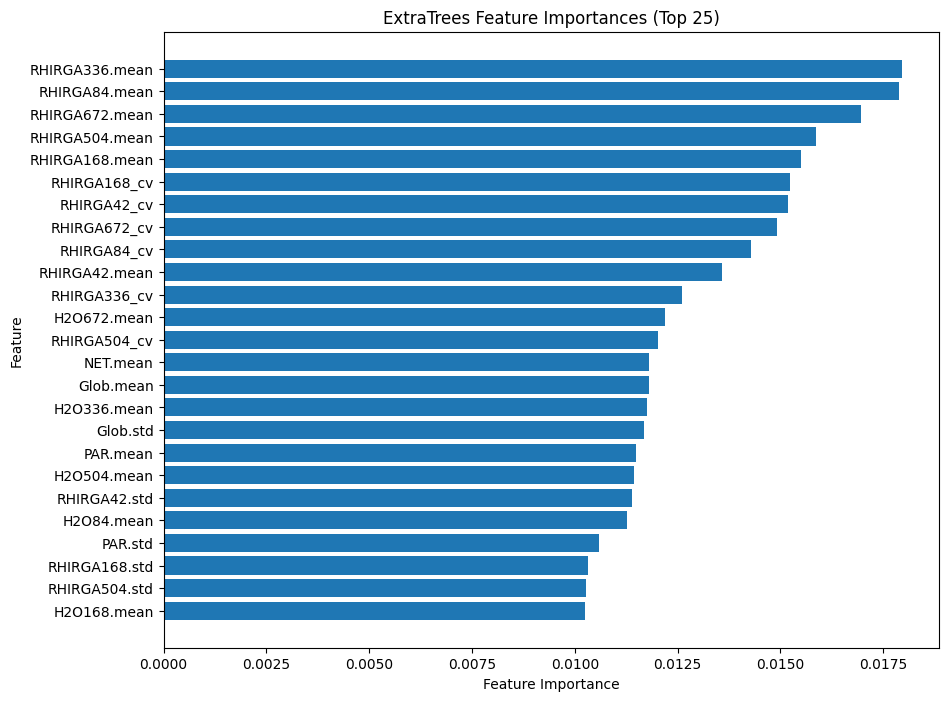

ExtraTrees metrics: {'multiclass_logloss': 0.7999455656453983, 'class4_accuracy': 0.6466666666666666, 'binary_logloss': 0.34543862616340026, 'class2_accuracy': 0.8622222222222222, 'perplexity': 1.4126093912371698}


In [7]:
# Cell 5 - ExtraTrees multiclass
with mlflow.start_run(run_name="03_extratrees"):  
    et = ExtraTreesClassifier(n_estimators=400, random_state=42)
    oof_et = oof_predict_proba(et, X_fe, y_class4, cv)
    np.save("../models/oof_extratrees_multiclass.npy", oof_et)
    metrics_et = multiclass_and_binary_metrics(
        y_class4, oof_et, nonevent_label="nonevent", class_list=class_list
    )
    mlflow.log_params({"model": "ExtraTrees", "n_estimators": 400})
    mlflow.log_metrics(metrics_et)

    # Fit model for feature importances
    et.fit(X_fe, y_class4)
    fi = et.feature_importances_
    fi_df = pd.DataFrame({
        "feature": X_fe.columns,
        "importance": fi
    }).sort_values("importance", ascending=False)
    fi_df.to_csv("../logs/metrics/extratrees_feature_importances.csv", index=False)
    mlflow.log_artifact("../logs/metrics/extratrees_feature_importances.csv")

    # ---------------------------------------------
    # NEW: Plot + save + log feature importance
    # ---------------------------------------------
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    top_k = 25  # Plot top 25 features
    fi_top = fi_df.head(top_k)
    plt.barh(fi_top["feature"], fi_top["importance"])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("ExtraTrees Feature Importances (Top 25)")
    plt.gca().invert_yaxis()  # Most important at top
    fpath = "../logs/eda_plots/extratrees_feat_importance.png"
    plt.savefig(fpath, dpi=250, bbox_inches="tight")
    mlflow.log_artifact(fpath)
    plt.show()
    # ---------------------------------------------

    # Save the fitted model
    joblib.dump(et, "../models/et_fit_for_featimp.joblib")
    mlflow.log_artifact("../models/et_fit_for_featimp.joblib")

    # Save metrics summary
    save_df(
        pd.DataFrame([metrics_et]).assign(model="ExtraTrees"),
        "../logs/metrics/model_search_metrics_extratrees.csv"
    )

    print("ExtraTrees metrics:", metrics_et)


In [9]:
# Cell 6 - XGBoost multiclass (quick default parameters)
with mlflow.start_run(run_name="03_xgb"):
    xgb_clf = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=len(class_list),
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42
    )
    oof_xgb = oof_predict_proba(xgb_clf, X_fe, y_class4, cv)
    np.save("../models/oof_xgb_multiclass.npy", oof_xgb)
    metrics_xgb = multiclass_and_binary_metrics(y_class4, oof_xgb, nonevent_label="nonevent", class_list=class_list)
    mlflow.log_params({"model":"XGBoost", "n_estimators":300, "max_depth":4})
    mlflow.log_metrics(metrics_xgb)
    save_df(pd.DataFrame([metrics_xgb]).assign(model="XGBoost"), "../logs/metrics/model_search_metrics_xgb.csv")
    print("XGB metrics:", metrics_xgb)


XGB metrics: {'multiclass_logloss': 0.9266884927585958, 'class4_accuracy': 0.6577777777777778, 'binary_logloss': 0.37414533541678413, 'class2_accuracy': 0.86, 'perplexity': 1.4537484162362535}


In [11]:
# Cell 7 - LightGBM multiclass (quick)
with mlflow.start_run(run_name="03_lgbm"):
    lgbm_clf = lgb.LGBMClassifier(
        objective="multiclass",
        num_class=len(class_list),
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )
    oof_lgbm = oof_predict_proba(lgbm_clf, X_fe, y_class4, cv)
    np.save("../models/oof_lgbm_multiclass.npy", oof_lgbm)
    metrics_lgbm = multiclass_and_binary_metrics(y_class4, oof_lgbm, nonevent_label="nonevent", class_list=class_list)
    mlflow.log_params({"model":"LightGBM", "n_estimators":400})
    mlflow.log_metrics(metrics_lgbm)
    save_df(pd.DataFrame([metrics_lgbm]).assign(model="LightGBM"), "../logs/metrics/model_search_metrics_lgbm.csv")
    print("LGBM metrics:", metrics_lgbm)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18346
[LightGBM] [Info] Number of data points in the train set: 360, number of used features: 152
[LightGBM] [Info] Start training from score -1.353505
[LightGBM] [Info] Start training from score -2.841582
[LightGBM] [Info] Start training from score -1.696449
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [12]:
# Cell 8 - Feature Engineered - Logistic Regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

with mlflow.start_run(run_name="03_lr"):
    lr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000))
    ])
    oof_lr = oof_predict_proba(lr_pipe, X_fe, y_class4, cv)
    np.save("../models/oof(fe)_lr_multiclass.npy", oof_lr)
    metrics_lr = multiclass_and_binary_metrics(y_class4, oof_lr, nonevent_label="nonevent", class_list=class_list)
    mlflow.log_params({
        "model":"LogisticRegression",
        "solver":"lbfgs",
        "max_iter":2000
        })
    mlflow.log_metrics(metrics_lr)
    save_df(pd.DataFrame([metrics_lr]).assign(model="LogisticRegression"), "../logs/metrics/model_search_metrics_lr.csv")
    print("LR metrics:", metrics_lr)


/home/ayesh/miniforge3/envs/npf-classifier/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ayesh/miniforge3/envs/npf-classifier/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ayesh/miniforge3/envs/npf-classifier/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ayesh/miniforge3/envs/npf-classifier/lib/py

LR metrics: {'multiclass_logloss': 1.3313079571206778, 'class4_accuracy': 0.6488888888888888, 'binary_logloss': 0.6526748195797115, 'class2_accuracy': 0.86, 'perplexity': 1.920671413764387}


In [15]:
from sklearn.ensemble import RandomForestClassifier

# Cell 6 - Baseline 2: Random Forest (multiclass)
with mlflow.start_run(run_name="02_baseline_rf_multiclass"):
    rf = RandomForestClassifier(n_estimators=300, random_state=42)
    oof_rf = oof_predict_proba(rf, X_fe, y_class4, cv)
    np.save("../models/oof_rf(fe)_multiclass.npy", oof_rf)
    metrics_rf = multiclass_and_binary_metrics(y_class4, oof_rf, nonevent_label="nonevent", class_list=class_list)
    mlflow.log_params({"model":"RandomForest", "n_estimators":300})
    mlflow.log_metrics(metrics_rf)
    save_df(pd.DataFrame([metrics_rf]).assign(model="RandomForest"), "../logs/metrics/model_search_metrics_rf.csv")
    print("RF metrics:", metrics_rf)


RF metrics: {'multiclass_logloss': 0.7880696712222295, 'class4_accuracy': 0.6533333333333333, 'binary_logloss': 0.3514105832498544, 'class2_accuracy': 0.8488888888888889, 'perplexity': 1.4210706739631196}


In [14]:
rows = []
rows.append({"model":"ExtraTrees", **metrics_et})
rows.append({"model":"XGBoost", **metrics_xgb})
rows.append({"model":"LightGBM", **metrics_lgbm})
rows.append({"model":"LogisticRegression", **metrics_lr})
rows.append({"model":"RandomForest", **metrics_rf})
df_summary = pd.DataFrame(rows)
save_df(df_summary, "../logs/metrics/model_search_metrics_summary.csv")
df_summary

,model,multiclass_logloss,class4_accuracy,binary_logloss,class2_accuracy,perplexity
0,ExtraTrees,0.799946,0.646667,0.345439,0.862222,1.412609
1,XGBoost,0.926688,0.657778,0.374145,0.860000,1.453748
2,LightGBM,1.718642,0.646667,0.660563,0.860000,1.935882
3,LogisticRegression,1.331308,0.648889,0.652675,0.860000,1.920671
4,RandomForest,0.788070,0.653333,0.351411,0.848889,1.421071


## Re-evaluating ExtraTrees, XGB, LGBM without engineered features

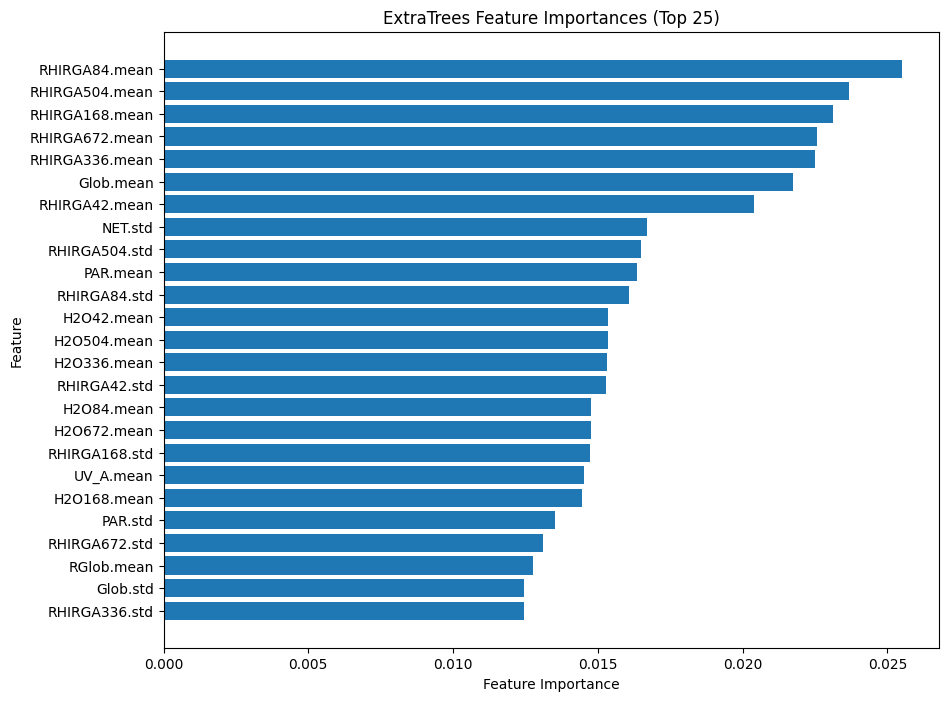

ExtraTrees metrics: {'multiclass_logloss': 0.8026144141608295, 'class4_accuracy': 0.6577777777777778, 'binary_logloss': 0.34694618518331144, 'class2_accuracy': 0.8711111111111111, 'perplexity': 1.4147405893163472}


In [18]:
# ExtraTrees multiclass (without engineered features)
with mlflow.start_run(run_name="03_extratrees_no_fe"):  
    et = ExtraTreesClassifier(n_estimators=400, random_state=42)
    oof_et = oof_predict_proba(et, X, y_class4, cv)
    np.save("../models/oof_extratrees_no_fe_multiclass.npy", oof_et)
    metrics_et_no_fe = multiclass_and_binary_metrics(
        y_class4, oof_et, nonevent_label="nonevent", class_list=class_list
    )
    mlflow.log_params({"model": "ExtraTrees", "n_estimators": 400})
    mlflow.log_metrics(metrics_et_no_fe)

    # Fit model for feature importances
    et.fit(X, y_class4)
    fi = et.feature_importances_
    fi_df = pd.DataFrame({
        "feature": X.columns,
        "importance": fi
    }).sort_values("importance", ascending=False)
    fi_df.to_csv("../logs/metrics/extratrees_no_fe_feature_importances.csv", index=False)
    mlflow.log_artifact("../logs/metrics/extratrees_no_fe_feature_importances.csv")

    # ---------------------------------------------
    # NEW: Plot + save + log feature importance
    # ---------------------------------------------
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    top_k = 25  # Plot top 25 features
    fi_top = fi_df.head(top_k)
    plt.barh(fi_top["feature"], fi_top["importance"])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("ExtraTrees Feature Importances (Top 25)")
    plt.gca().invert_yaxis()  # Most important at top
    fpath = "../logs/eda_plots/extratrees_no_fe_feat_importance.png"
    plt.savefig(fpath, dpi=250, bbox_inches="tight")
    mlflow.log_artifact(fpath)
    plt.show()
    # ---------------------------------------------

    # Save the fitted model
    joblib.dump(et, "../models/et_fit_no_fe_for_featimp.joblib")
    mlflow.log_artifact("../models/et_fit_no_fe_for_featimp.joblib")

    # Save metrics summary
    save_df(
        pd.DataFrame([metrics_et_no_fe]).assign(model="ExtraTrees"),
        "../logs/metrics/model_search_metrics_extratrees_no_fe.csv"
    )

    print("ExtraTrees metrics:", metrics_et_no_fe)


In [19]:
# XGBoost multiclass (quick default parameters) - without engineered features
with mlflow.start_run(run_name="03_xgb_no_fe"):
    xgb_clf = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=len(class_list),
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42
    )
    oof_xgb = oof_predict_proba(xgb_clf, X, y_class4, cv)
    np.save("../models/oof_xgb_no_fe_multiclass.npy", oof_xgb)
    metrics_xgb_no_fe = multiclass_and_binary_metrics(y_class4, oof_xgb, nonevent_label="nonevent", class_list=class_list)
    mlflow.log_params({"model":"XGBoost", "n_estimators":300, "max_depth":4})
    mlflow.log_metrics(metrics_xgb_no_fe)
    save_df(pd.DataFrame([metrics_xgb_no_fe]).assign(model="XGBoost"), "../logs/metrics/model_search_metrics_xgb_no_fe.csv")
    print("XGB metrics:", metrics_xgb_no_fe)


XGB metrics: {'multiclass_logloss': 0.9692650510491844, 'class4_accuracy': 0.6422222222222222, 'binary_logloss': 0.3803055465505181, 'class2_accuracy': 0.8555555555555555, 'perplexity': 1.4627314537118448}


In [20]:
# LightGBM multiclass (quick) - without engineered features
with mlflow.start_run(run_name="03_lgbm_no_fe"):
    lgbm_clf = lgb.LGBMClassifier(
        objective="multiclass",
        num_class=len(class_list),
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    )
    oof_lgbm = oof_predict_proba(lgbm_clf, X, y_class4, cv)
    np.save("../models/oof_lgbm_no_fe_multiclass.npy", oof_lgbm)
    metrics_lgbm_no_fe = multiclass_and_binary_metrics(y_class4, oof_lgbm, nonevent_label="nonevent", class_list=class_list)
    mlflow.log_params({"model":"LightGBM", "n_estimators":400})
    mlflow.log_metrics(metrics_lgbm_no_fe)
    save_df(pd.DataFrame([metrics_lgbm_no_fe]).assign(model="LightGBM"), "../logs/metrics/model_search_metrics_lgbm_no_fe.csv")
    print("LGBM metrics:", metrics_lgbm_no_fe)


LGBM metrics: {'multiclass_logloss': 1.940194976301598, 'class4_accuracy': 0.6244444444444445, 'binary_logloss': 0.7606081164016013, 'class2_accuracy': 0.8422222222222222, 'perplexity': 2.1395769367910287}


In [21]:
rows = []
rows.append({"model":"ExtraTrees", **metrics_et})
rows.append({"model":"ExtraTrees_no_fe", **metrics_et_no_fe})
rows.append({"model":"XGBoost", **metrics_xgb})
rows.append({"model":"XGBoost_no_fe", **metrics_xgb_no_fe})
rows.append({"model":"LightGBM", **metrics_lgbm})
rows.append({"model":"LightGBM_no_fe", **metrics_lgbm_no_fe})
df_summary = pd.DataFrame(rows)
save_df(df_summary, "../logs/metrics/model_search_metrics_no_fe_summary.csv")
df_summary

,model,multiclass_logloss,class4_accuracy,binary_logloss,class2_accuracy,perplexity
0,ExtraTrees,0.799946,0.646667,0.345439,0.862222,1.412609
1,ExtraTrees_no_fe,0.802614,0.657778,0.346946,0.871111,1.414741
2,XGBoost,0.926688,0.657778,0.374145,0.860000,1.453748
3,XGBoost_no_fe,0.969265,0.642222,0.380306,0.855556,1.462731
4,LightGBM,1.718642,0.646667,0.660563,0.860000,1.935882
5,LightGBM_no_fe,1.940195,0.624444,0.760608,0.842222,2.139577
